In [397]:
import torch
import pandas as pd
import torch.utils.data as data
from sklearn.preprocessing import MinMaxScaler
from typing import List
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassAccuracy

In [398]:
train_data = pd.read_csv('../data/train_data.csv', index_col=0)

In [399]:
train_data

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
SalePrice,,,,,,,,,,,,,,,,
141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570796,2007,1928,24,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
307079,2015,644,22,terraced,individual_heating,management_in_trust,102.0,400.0,0~5min,5min~10min,5.0,10.0,Daegu,7,7.0,11.0
357522,2007,868,20,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0


# Display number of unique elements in each column

In [400]:
for column in train_data.columns:
    print(f"Number of unique rows in {column}: {train_data[column].nunique()}")


Number of unique rows in YearBuilt: 16
Number of unique rows in Size(sqf): 89
Number of unique rows in Floor: 43
Number of unique rows in HallwayType: 3
Number of unique rows in HeatingType: 2
Number of unique rows in AptManageType: 2
Number of unique rows in N_Parkinglot(Ground): 23
Number of unique rows in N_Parkinglot(Basement): 20
Number of unique rows in TimeToBusStop: 3
Number of unique rows in TimeToSubway: 5
Number of unique rows in N_manager: 9
Number of unique rows in N_elevators: 13
Number of unique rows in SubwayStation: 8
Number of unique rows in N_FacilitiesInApt: 9
Number of unique rows in N_FacilitiesNearBy(Total): 11
Number of unique rows in N_SchoolNearBy(Total): 14


In [401]:
COLUMNS_TO_DUMMY = ["HeatingType","AptManageType", "HallwayType","TimeToBusStop","TimeToSubway","SubwayStation"]
OUTPUT_COLUMN = "SalePrice"

In [402]:
CRITERIUM_MAX_AVERAGE = 350000
CRITERIUM_MAX_CHEAP = 100000

In [403]:
def classify(tensor) -> torch.tensor:
    return torch.where(tensor > CRITERIUM_MAX_AVERAGE, torch.tensor(2),
                       torch.where((tensor > CRITERIUM_MAX_CHEAP) & (tensor <= CRITERIUM_MAX_AVERAGE), torch.tensor(1),
                                   torch.tensor(0)))

In [404]:
def count_unique_elements(tensor):
    unique_elements, counts = torch.unique(tensor, return_counts=True)
    for unique, count in zip(unique_elements, counts):
        print(f"Class {unique.item()}: {count.item()} occurrences")

In [405]:
class HouseDataset(data.Dataset):
    def __init__(self, path_to_csv: str, scaler = None) -> None:
        super().__init__()
        self.data = pd.read_csv(path_to_csv)
        self.scaler = scaler
        self.label = torch.tensor(self.data.iloc[:,0].values, dtype=torch.float32)
        self._prepare_data()
        self.data = torch.tensor(self.data.iloc[:,1:].values, dtype=torch.float32)
        self.size = self.data.shape[0]
    
    def __len__(self) -> int:
        return self.size
    
    def __getitem__(self, idx) -> tuple[torch.tensor, torch.tensor]:
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label
    def _to_dummy_columns(self, columns: List[str]) -> pd.DataFrame:
        dummy_columns = pd.get_dummies(self.data, columns=columns).astype(float)
        return dummy_columns
    
    def get_non_dummy_columns(self) -> List[str]:
        return [column for column in self.data.columns if column not in COLUMS_TO_DUMMY]
    
    def _scale_data(self) -> None:
        for column in self.data:
            if column not in COLUMS_TO_DUMMY or column != OUTPUT_COLUMN:
                self.data[column] = self.scaler.fit_transform(self.data[column].values.reshape(-1, 1))
        
    def _prepare_data(self) -> None:
        self.data = self._to_dummy_columns(columns=COLUMS_TO_DUMMY)
        if self.scaler:
            self._scale_data()
    
    def get_data_as_pandas(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        data = pd.DataFrame(self.data.numpy())
        labels = pd.DataFrame(self.label.numpy())
        return data, labels
        
        
        

In [406]:
path = '../data/train_data.csv'
scaler = MinMaxScaler()
train_dataset = HouseDataset(path, scaler)

In [407]:
train_data, train_labels = train_dataset.get_data_as_pandas()

In [408]:
train_labels

,0
0,141592.0
1,51327.0
2,48672.0
3,380530.0
4,78318.0
...,...
4119,570796.0
4120,307079.0
4121,357522.0
4122,312389.0


In [409]:
train_data

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.756757,0.308356,0.047619,0.155680,0.139288,0.153846,0.000000,0.444444,0.3750,0.529412,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.189189,0.205268,0.166667,0.112202,0.057532,0.076923,0.074074,0.222222,0.7500,0.235294,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.189189,0.205268,0.119048,0.112202,0.057532,0.076923,0.074074,0.222222,0.7500,0.235294,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.756757,0.872389,0.166667,0.349229,0.405753,0.307692,0.407407,0.444444,0.1875,0.411765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.378378,0.231154,0.023810,0.199158,0.059803,0.230769,0.296296,0.222222,0.5625,0.823529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,0.783784,0.814260,0.547619,0.000000,0.961393,1.000000,0.592593,1.000000,0.5625,0.588235,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4120,1.000000,0.231154,0.500000,0.143058,0.302801,0.307692,0.370370,0.666667,0.4375,0.647059,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4121,0.783784,0.332879,0.452381,0.000000,0.961393,1.000000,0.592593,1.000000,0.5625,0.588235,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4122,0.000000,0.541326,0.000000,0.122020,0.000000,0.000000,0.148148,0.222222,0.4375,0.647059,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [410]:
labels = classify(train_dataset.label)
count_unique_elements(labels)

Class 0: 562 occurrences
Class 1: 2992 occurrences
Class 2: 570 occurrences


In [411]:
path = '../data/train_data.csv'
scaler = MinMaxScaler()
train_dataset = HouseDataset(path, scaler)

# Split the data into training and validation sets

In [412]:
X_train, X_test, y_train, y_test = train_test_split(train_dataset.data, train_dataset.label, test_size=0.2, random_state=42)
train_data = data.TensorDataset(X_train, y_train)
validation_data = data.TensorDataset(X_test, y_test)

# Create the data loaders

In [413]:
batch_size = 32
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [414]:
for data, label in train_loader:
    print(data, label)

tensor([[0.7838, 0.6848, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.8378, 0.4655, 0.1190,  ..., 0.0000, 0.0000, 1.0000],
        [0.3784, 0.0999, 0.2143,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [0.7568, 0.5913, 0.4286,  ..., 0.0000, 1.0000, 0.0000],
        [0.3784, 0.3538, 0.0952,  ..., 1.0000, 0.0000, 0.0000],
        [0.8108, 0.3152, 0.1190,  ..., 0.0000, 1.0000, 0.0000]]) tensor([433628., 191938.,  38938., 290265., 209734., 191150., 378761., 300000.,
        231858.,  75088., 345132.,  34070., 336283., 307079., 153097., 238053.,
        212389.,  37610., 365486., 286902., 272566., 306194., 350442., 110619.,
        169911., 247787., 331858., 121238., 300884., 307964., 221238., 218584.])
tensor([[0.7568, 0.3102, 0.2619,  ..., 0.0000, 1.0000, 0.0000],
        [0.9459, 0.2312, 0.2381,  ..., 0.0000, 0.0000, 0.0000],
        [0.7838, 0.5686, 0.2619,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.9730, 0.3520, 0.0714,  ..., 1.0000, 0.0000, 0.0000],
        [0.7

In [415]:
class HousingRegressionModel(nn.Module):
    def __init__(self, input_size: int, output_size: int) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout = nn.Dropout(0.1)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [416]:
model = HousingRegressionModel(input_size=train_dataset.data.shape[1], output_size=1)

In [417]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=0.01)

In [418]:
loss_fn = nn.MSELoss()

In [419]:
mca = MulticlassAccuracy(num_classes=3, average=None)

In [420]:
EPOCHS_NUMBER = 1000
train_losses,train_accuracies, val_losses, val_accuracies  = [], [], [], []
tqdm_progress = tqdm(range(EPOCHS_NUMBER))
for epoch in tqdm_progress:
    train_batch_loss_sum, val_batch_loss_sum = 0, 0
    train_batch_accuracy_sum, val_batch_accuracy_sum = 0, 0
    model.train()
    batch_idx = 0
    for data, label in train_loader:
        optimizer.zero_grad()
        model_output = model(data).squeeze()
        loss = loss_fn(model_output, label)
        loss.backward()
        optimizer.step()
        train_batch_loss_sum += loss.item()
        batch_idx += 1
        train_predicts_classify = classify(model_output)
        train_data_classify = classify(label)
        train_batch_accuracy_sum += mca(train_predicts_classify, train_data_classify)
    train_batch_accuracy_avg = train_batch_accuracy_sum/batch_idx
    mean_error_train = train_batch_loss_sum/len(train_loader)
    train_losses.append(mean_error)
    train_accuracies.append(train_batch_accuracy_avg)
    model.eval()
    batch_val_idx = 0
    for val_inputs, val_labels in validation_loader:
        val_predicts = model(val_inputs).squeeze(dim=1)
        val_loss = loss_fn(val_predicts, val_labels)
        val_batch_loss_sum += val_loss.item()
        train_batch_loss = train_batch_loss_sum / (len(train_loader.dataset))
        val_batch_loss = val_batch_loss_sum / (len(validation_loader.dataset))
        train_losses.append(train_batch_loss)
        val_losses.append(val_batch_loss)
        batch_val_idx += 1
        val_predicts_classify = classify(val_predicts)
        val_data_classify = classify(val_labels)
        val_batch_accuracy_sum += mca(val_predicts_classify, val_data_classify)
    val_batch_accuracy_avg = val_batch_accuracy_sum/batch_val_idx
    mean_error_val = val_batch_loss_sum/len(train_loader)
    tqdm_progress.set_postfix({"Epoch": epoch+1, "Loss in train": {mean_error_train}, "Loss in eval": {mean_error_val}})
    val_accuracies.append(val_batch_accuracy_avg)
    val_losses.append(mean_error_val)

100%|██████████| 1000/1000 [02:09<00:00,  7.75it/s, Epoch=1000, Loss in train={2129030701.643411}, Loss in eval={1850500044.4031007}]


In [421]:
train_accuracies

[tensor([0.4708, 0.7189, 0.0813]),
 tensor([0.4781, 0.9368, 0.3170]),
 tensor([0.4691, 0.9326, 0.4939]),
 tensor([0.4741, 0.9171, 0.5469]),
 tensor([0.5367, 0.9234, 0.6002]),
 tensor([0.5288, 0.9231, 0.6308]),
 tensor([0.5116, 0.9238, 0.6539]),
 tensor([0.5210, 0.9187, 0.6385]),
 tensor([0.5422, 0.9249, 0.6561]),
 tensor([0.5290, 0.9243, 0.6733]),
 tensor([0.5120, 0.9194, 0.6505]),
 tensor([0.5477, 0.9265, 0.6785]),
 tensor([0.5644, 0.9237, 0.6561]),
 tensor([0.5692, 0.9262, 0.6573]),
 tensor([0.5299, 0.9257, 0.6785]),
 tensor([0.5369, 0.9208, 0.6606]),
 tensor([0.5500, 0.9204, 0.6827]),
 tensor([0.5556, 0.9221, 0.7119]),
 tensor([0.5818, 0.9231, 0.6781]),
 tensor([0.5731, 0.9208, 0.6810]),
 tensor([0.5712, 0.9228, 0.6933]),
 tensor([0.5281, 0.9169, 0.6813]),
 tensor([0.5883, 0.9226, 0.6774]),
 tensor([0.5607, 0.9174, 0.6869]),
 tensor([0.5692, 0.9209, 0.6837]),
 tensor([0.5256, 0.9215, 0.6407]),
 tensor([0.5436, 0.9161, 0.7163]),
 tensor([0.5439, 0.9213, 0.7046]),
 tensor([0.5777, 0.9

In [422]:
val_accuracies

[tensor([0.5611, 0.9642, 0.0751]),
 tensor([0.5857, 0.9317, 0.3747]),
 tensor([0.4439, 0.9400, 0.6614]),
 tensor([0.5223, 0.9392, 0.6457]),
 tensor([0.5786, 0.9191, 0.7076]),
 tensor([0.6049, 0.9383, 0.5124]),
 tensor([0.5262, 0.9375, 0.7024]),
 tensor([0.5422, 0.9304, 0.7091]),
 tensor([0.5472, 0.9188, 0.7943]),
 tensor([0.4743, 0.9270, 0.7794]),
 tensor([0.5381, 0.9356, 0.7504]),
 tensor([0.5360, 0.9270, 0.7525]),
 tensor([0.5125, 0.9171, 0.8108]),
 tensor([0.5191, 0.9255, 0.7875]),
 tensor([0.5404, 0.9284, 0.7982]),
 tensor([0.5552, 0.9286, 0.7853]),
 tensor([0.5414, 0.9270, 0.7288]),
 tensor([0.5879, 0.9464, 0.6087]),
 tensor([0.5816, 0.9362, 0.6297]),
 tensor([0.3642, 0.9554, 0.7738]),
 tensor([0.4339, 0.9279, 0.8153]),
 tensor([0.7116, 0.8970, 0.7409]),
 tensor([0.5692, 0.9333, 0.7686]),
 tensor([0.5806, 0.9320, 0.6443]),
 tensor([0.5256, 0.9382, 0.6749]),
 tensor([0.5391, 0.9296, 0.8087]),
 tensor([0.3347, 0.9375, 0.8068]),
 tensor([0.5660, 0.9322, 0.7321]),
 tensor([0.5318, 0.9

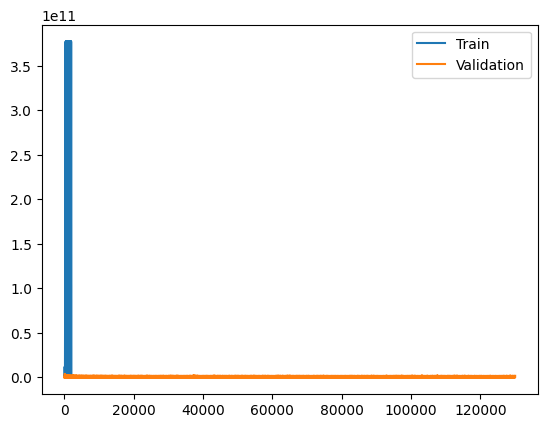

In [423]:
plt.plot(loss_train,label="Train")
plt.plot(val_losses, label="Validation")
plt.legend()

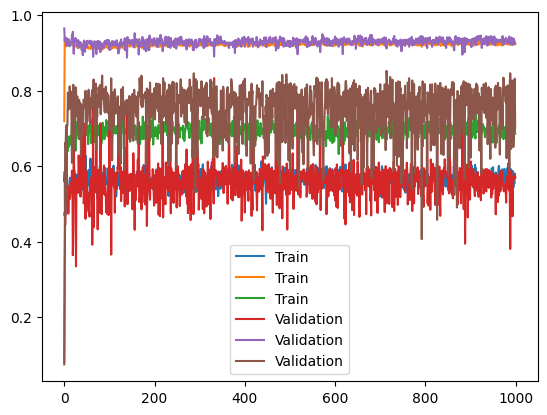

In [424]:
plt.plot(train_accuracies, label="Train")
plt.plot(val_accuracies, label="Validation")
plt.legend()

In [425]:
train_accuracies_mean = [tensor.mean().item() for tensor in train_accuracies]

In [426]:
train_accuracies_mean

[0.42364123463630676,
 0.5772969126701355,
 0.6318777799606323,
 0.6460160613059998,
 0.6867652535438538,
 0.6942623257637024,
 0.6964237093925476,
 0.6927555203437805,
 0.7077538371086121,
 0.7088429927825928,
 0.6939878463745117,
 0.7175710797309875,
 0.7147172093391418,
 0.7175430655479431,
 0.7113711833953857,
 0.7061030268669128,
 0.7176931500434875,
 0.7298476099967957,
 0.7276710867881775,
 0.7249848246574402,
 0.729078471660614,
 0.7087731957435608,
 0.7294511795043945,
 0.7216603755950928,
 0.7246384620666504,
 0.6959385275840759,
 0.7253414988517761,
 0.7232584357261658,
 0.727058470249176,
 0.7262676358222961,
 0.7334792017936707,
 0.7207439541816711,
 0.7087252736091614,
 0.7343881130218506,
 0.7229825854301453,
 0.7304067611694336,
 0.720288097858429,
 0.7082903981208801,
 0.7149501442909241,
 0.7266117930412292,
 0.7131462693214417,
 0.7108407020568848,
 0.718921959400177,
 0.7283298373222351,
 0.7189742922782898,
 0.7185534834861755,
 0.7108538150787354,
 0.7435303330421